<a href="https://colab.research.google.com/github/jegonzalezga/IntroModelosDeAprendizaje/blob/master/Semana8_RedNeuronalRecurrente_LSTMBidireccional_Actividad_Grupo6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

Daniela Carolina Sanabria

Juan Camilo Marín

Jorge Enrique González

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [1]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [2]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [3]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 0s 0us/step
25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [4]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [5]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

1646592/1641221 [==============================] - 0s 0us/step


Veamos el primer comentario de entrenamiento que es positivo:

In [6]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [7]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [8]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 29s 75ms/step - loss: 0.4392 - accuracy: 0.7949 - val_loss: 0.4765 - val_accuracy: 0.7718
Epoch 2/3
391/391 [==============================] - 28s 71ms/step - loss: 0.2145 - accuracy: 0.9215 - val_loss: 0.3532 - val_accuracy: 0.8566
Epoch 3/3
391/391 [==============================] - 27s 70ms/step - loss: 0.1193 - accuracy: 0.9603 - val_loss: 0.4570 - val_accuracy: 0.8569
Desempeño (exactitud): accu_v1=0.8568800091743469 , accu_v2=0.8385999798774719
Epoch 1/3
391/391 [==============================] - 29s 74ms/step - loss: 0.2421 - accuracy: 0.9098 - val_loss: 0.2099 - val_accuracy: 0.9236
Epoch 2/3
391/391 [==============================] - 28s 71ms/step - loss: 0.1151 - accuracy: 0.9623 - val_loss: 0.2615 - val_accuracy: 0.9119
Epoch 3/3
391/391 [==============================] - 28s 70ms/step - loss: 0.0765 - accuracy: 0.9754 - val_loss: 0.3477 - val_accuracy: 0.8982
Desempeño (exactitud): accu_v1=0.8981599807739258 , accu_v2=0.8

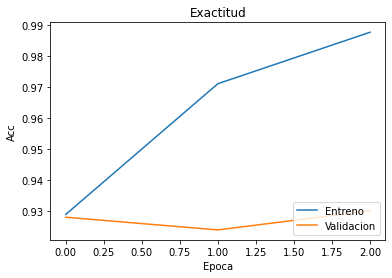

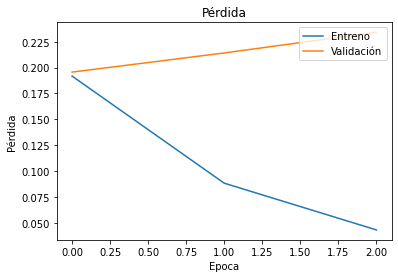

In [10]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [11]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [12]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11708   792]
 [ 1252 11248]]
Exactitud:  0.9182400107383728


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [13]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10988  1512]
 [ 2523  9977]]
Exactitud:  0.8385999798774719


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

In [28]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM
x = (layers.LSTM(150, return_sequences=True))(x)
x = (layers.LSTM(94))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model2 = keras.Model(inputs, outputs)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model2.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 150)         167400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 94)                92120     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 95        
Total params: 2,819,615
Trainable params: 2,819,615
Non-trainable params: 0
_________________________________________________________________


In [35]:
    # Ajustamos el modelo
    model2.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)   
    # Calculamos las metricas
    train_metrics = model2.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model2.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model2.evaluate(x=x_val, y=y_val, verbose=0)

Epoch 1/3
391/391 [==============================] - 21s 54ms/step - loss: 0.0142 - accuracy: 0.9968 - val_loss: 0.7219 - val_accuracy: 0.8377
Epoch 2/3
391/391 [==============================] - 21s 53ms/step - loss: 0.0100 - accuracy: 0.9974 - val_loss: 0.6324 - val_accuracy: 0.8492
Epoch 3/3
391/391 [==============================] - 21s 53ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.7794 - val_accuracy: 0.8476


In [36]:
Y_predt = model2.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model2.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11546   954]
 [  960 11540]]
Exactitud:  0.9234399795532227


In [37]:
Y_predv = model2.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model2.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[10586  1914]
 [ 2171 10329]]
Exactitud:  0.8366000056266785


Con un modelo LSTM se obtuvo un resultado bastante comparables con el modelo bidireccional con un accuracy de 0.9234 en entrenamiento, comparado con el accuracy de entrenamiento de la red bidireccional que fue de 0.9182. Por otro lado en validación la red bidireccional tuvo un mejor desempeño ya que la red sencilla tuvo una exactitud de 0.8366.

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

Con el fin de mejorar los resultados presentados anteriormente, se propone un nuevo modelo que incorcopora redes neuronales recurrentes y una capa de dropout del 20%. Asi mismo con el fin de incrementar el aprendizaje del modelo se aumentan las epocas de 3 a 10. 

In [23]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 capa GRU
x = (layers.GRU(100, return_sequences=True))(x)
x = layers.Dropout(.2)(x)
x = (layers.GRU(64))(x)

#salida binaria
outputs = layers.Dense(1, activation="sigmoid")(x)

# modelo
model12 = keras.Model(inputs, outputs)
model12.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model12.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_2 (GRU)                  (None, None, 100)         69000     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                31872     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,660,937
Trainable params: 2,660,937
Non-trainable params: 0
___________________________________________

In [24]:
model12.fit(x=CE_x, y=CE_y, epochs= 10, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)  

Epoch 1/10
391/391 [==============================] - 22s 56ms/step - loss: 0.4741 - accuracy: 0.7672 - val_loss: 0.3072 - val_accuracy: 0.8756
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 0.1701 - accuracy: 0.9370 - val_loss: 0.3428 - val_accuracy: 0.8690
Epoch 3/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0566 - accuracy: 0.9827 - val_loss: 0.4380 - val_accuracy: 0.8706
Epoch 4/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0255 - accuracy: 0.9927 - val_loss: 0.5997 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.5556 - val_accuracy: 0.8706
Epoch 6/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.6150 - val_accuracy: 0.8704
Epoch 7/10
391/391 [==============================] - 20s 52ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.6739 - val_accuracy:

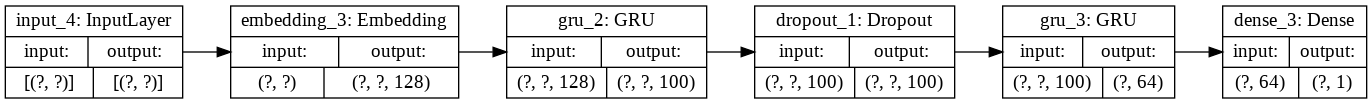

In [25]:
keras.utils.plot_model(model12, show_shapes=True, rankdir="LR")

In [26]:
Y_predt = model12.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model12.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[11800   700]
 [  975 11525]]
Exactitud:  0.9330000281333923


In [27]:
Y_predv = model12.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model12.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[11001  1499]
 [ 2241 10259]]
Exactitud:  0.8503999710083008


Se observa un mejoramiento en la exactitud tanto de la parte de prueba como la parte de validación, con niveles de exactitud del 93.3% y del 85.04% respectivamente.

El uso del dropout facilita el aprendizaje del modelo al brindarle nuevas conexiones que se adaptan mejor a los patrones que se presentan en los datos. Asi mismo aumentar el número de epocas las neuronas tienen las posibililidades de identificar facilmente los patrones de interes de los datos y de esta manera conseguir un mejor desempeño. 

Usar capas recurrentes ya sean LSTM o GRU mostraron un desempeño adecuado dentro del contexto del problema, se podrian hacer iteraciones variando la cantidad de neuronas, capas recurrentes  tasa de dropout y epocas buscando encontrar aquel modelo que consiga los mejores indicadores de desempeño.